In [4]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

In [5]:
# Helper function to marching cube meshes
def plotMesh(ax, mesh, ax_x, ax_y, ax_z, azim, elev):
    
    ax.add_collection3d(mesh)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_xlim(ax_x[0], ax_x[1])  
    ax.set_ylim(ax_y[0], ax_y[1])  
    ax.set_zlim(ax_z[0], ax_z[1]) 
    ax.set_aspect('equal')
    ax.azim = azim
    ax.elev = elev

## Display non-registered data

In [6]:
dataFolder = 'data/IE/scrambled/'
fixedFile = 'image12.nii' # ID 12 is the suggested reference
movingFile = 'image2.nii'

In [8]:
# Load the volumes - first the fixed image
nii_fix = nib.load(dataFolder + fixedFile)
nii_fix

In [9]:
affine_fix = nii_fix.affine # Define the transformation matrix defining the grid of the volume
affine_fix

array([[0.09788813, 0.        , 0.        , 0.        ],
       [0.        , 0.098     , 0.        , 0.        ],
       [0.        , 0.        , 0.098     , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

In [10]:
imgDim_fix = nii_fix.header['dim'][1:4]
imgSpacing_fix = nii_fix.header['pixdim'][1:4]
print('Fixed image dimensions and voxel size')
print(imgDim_fix)
print(imgSpacing_fix)

Fixed image dimensions and voxel size
[224 176 128]
[0.09788813 0.098      0.098     ]


In [11]:
# The the moving image
nii_mov = nib.load(dataFolder + movingFile)
affine_mov = nii_mov.affine # Define the transformation matrix defining the grid of the volume
imgDim_mov = nii_mov.header['dim'][1:4]
imgSpacing_mov = nii_mov.header['pixdim'][1:4]

print('Moving image dimensions and voxel size')
print(imgDim_mov)
print(imgSpacing_mov)

Moving image dimensions and voxel size
[292 229 166]
[0.075 0.075 0.075]


In [12]:
# print out the range of dimensions and voxel sizes of all 18 images
first_dimension = []
second_dimension = []
third_dimension = []
first_voxel_size = []
second_voxel_size = []
third_voxel_size = []
for i in range(1, 19):
    nii = nib.load(dataFolder + 'image' + str(i) + '.nii')
    imgDim = nii.header['dim'][1:4]
    imgSpacing = nii.header['pixdim'][1:4]
    first_dimension.append(imgDim[0])
    second_dimension.append(imgDim[1])
    third_dimension.append(imgDim[2])
    first_voxel_size.append(imgSpacing[0])
    second_voxel_size.append(imgSpacing[1])
    third_voxel_size.append(imgSpacing[2])

print(f'First dimension: {min(first_dimension)} - {max(first_dimension)}')
print(f'Second dimension: {min(second_dimension)} - {max(second_dimension)}')
print(f'Third dimension: {min(third_dimension)} - {max(third_dimension)}')    
print(f'First voxel size: {min(first_voxel_size)} - {max(first_voxel_size)}')
print(f'Second voxel size: {min(second_voxel_size)} - {max(second_voxel_size)}')
print(f'Third voxel size: {min(third_voxel_size)} - {max(third_voxel_size)}')

First dimension: 128 - 292
Second dimension: 128 - 229
Third dimension: 128 - 292
First voxel size: 0.07500000298023224 - 0.09788812696933746
Second voxel size: 0.07500000298023224 - 0.09799999743700027
Third voxel size: 0.07500000298023224 - 0.09799999743700027


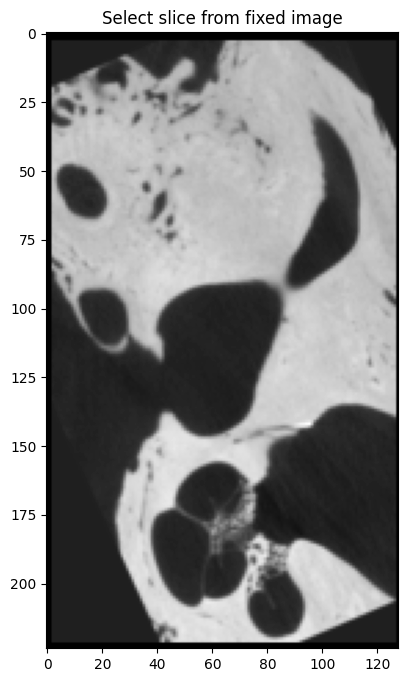

In [13]:
# Display a slice from the fixed image

## --- Choose slice --- ##
sliceFixed = 83 # Choose an approximate central slice from the longest axis
# NB: If using image12.nii as fixed - slice 83 or so is a good suggestion

## -------------------- ##

# Display selected slice
fig, ax = plt.subplots(1,1, figsize=(16, 8))
ax.imshow(nii_fix.get_fdata()[:,sliceFixed,:], cmap='gray')
ax.set_title('Select slice from fixed image')
plt.show()

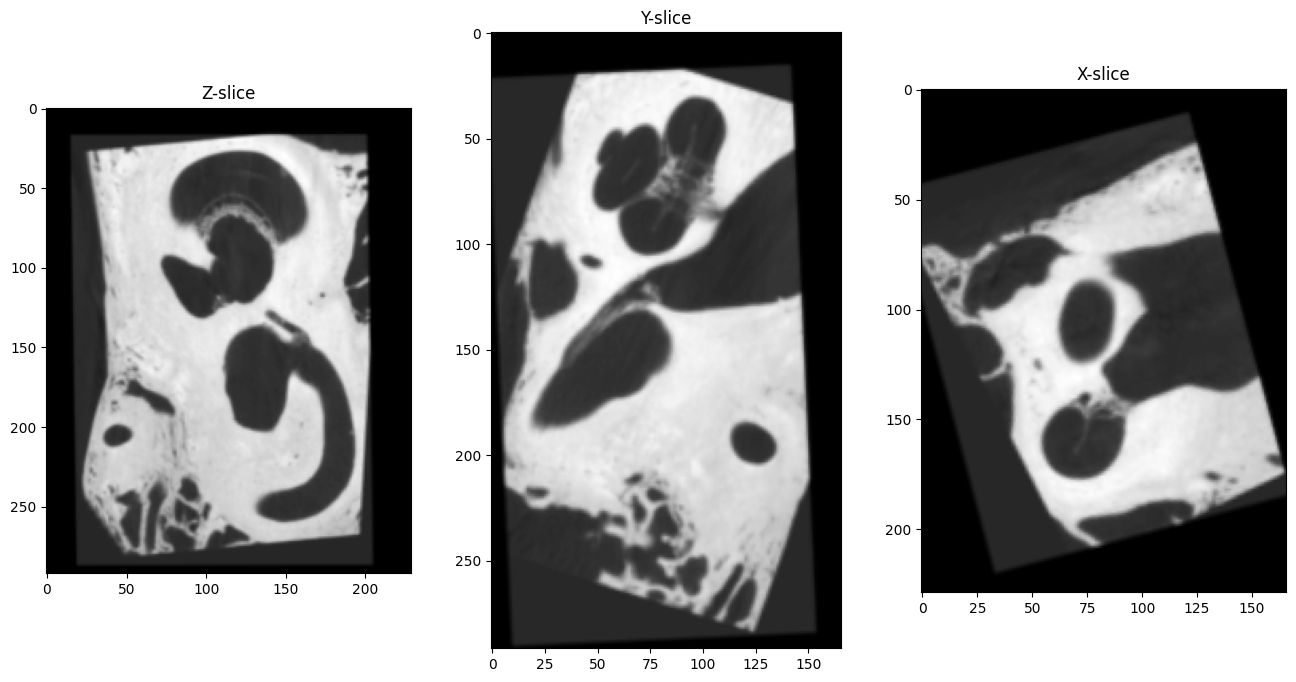

In [14]:
# Display a slice from the fixed image

## --- Choose slice --- ##
sliceMoving = 100
## -------------------- ##

# Showcase
fig, ax = plt.subplots(1,3, figsize=(16, 8))
ax[0].imshow(nii_mov.get_fdata()[:,:,sliceMoving], cmap='gray')
ax[0].set_title('Z-slice')
ax[1].imshow(nii_mov.get_fdata()[:,sliceMoving,:], cmap='gray')
ax[1].set_title('Y-slice')
ax[2].imshow(nii_mov.get_fdata()[sliceMoving,:,:], cmap='gray')
ax[2].set_title('X-slice')
plt.show()

# Register the data

In [16]:
## -- Load the aligned moving image -- ##

alignedFile = 'data/resliced_image_1.nii.gz'

## ----------------------------------- ##

# The the moving image
nii_aln = nib.load(alignedFile)
affine_aln = nii_aln.affine # Define the transformation matrix defining the grid of the volume
imgDim_aln = nii_aln.header['dim'][1:4]
imgSpacing_aln = nii_mov.header['pixdim'][1:4]

print('Aligned image dimensions and voxel size')
print(imgDim_aln)
print(imgSpacing_aln)

Aligned image dimensions and voxel size
[224 176 128]
[0.075 0.075 0.075]


Text(0.5, 1.0, 'Same slice from moving image ')

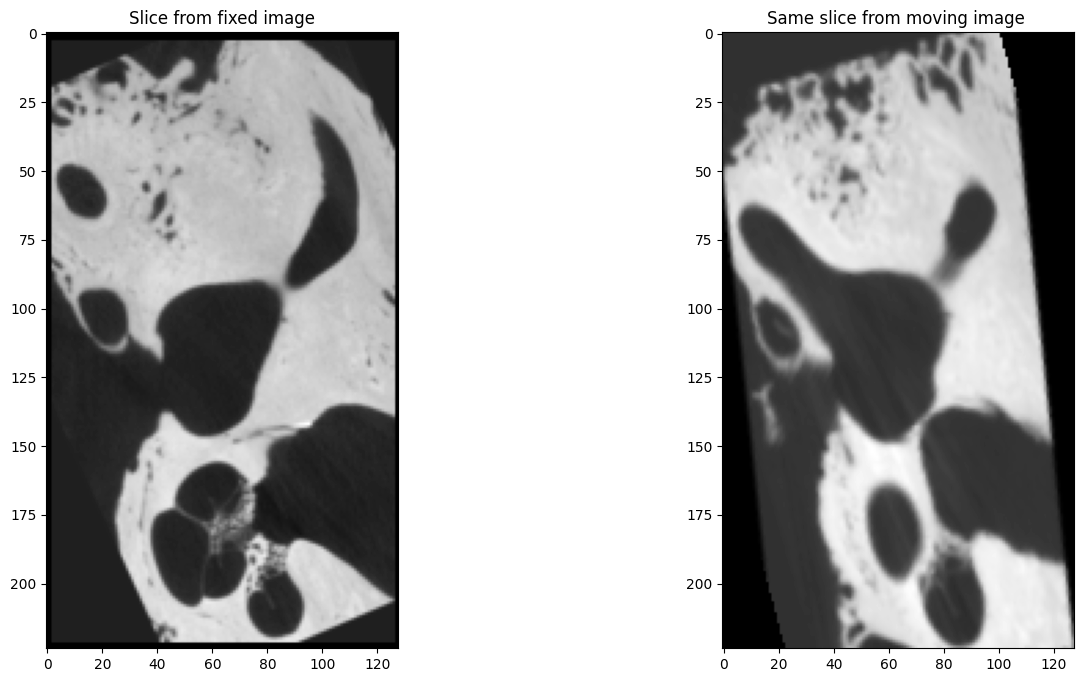

In [17]:
# Display the slice from the fixed and aligned image

fig, ax = plt.subplots(1,2, figsize=(16, 8))
ax[0].imshow(nii_fix.get_fdata()[:,sliceFixed,:], cmap='gray')
ax[0].set_title('Slice from fixed image')

ax[1].imshow(nii_aln.get_fdata()[:,sliceFixed,:], cmap='gray')
ax[1].set_title('Same slice from moving image ')

# Display segmentation data as meshes

In [18]:
#%%
# Load the segmentations of the chosen fixed, moving and aligned volumes

## -- The data files -- ##

fixedSegmentFile = 'data/IE/scrambled/label12.nii' # ID 12 is the suggested reference
movingSegmentFile = 'data/IE/scrambled/label1.nii'
alignSegmentFile = 'data/resliced_image_label1.nii.gz'

# Load the volumes
niiBin_fix = nib.load(fixedSegmentFile)
niiBin_mov = nib.load(movingSegmentFile)
niiBin_aln = nib.load(alignSegmentFile)

## ------------------------ ##

# Get the dimensions
imgDim_fix = niiBin_fix.header['dim'][1:4]
imgDim_mov = niiBin_mov.header['dim'][1:4]
imgDim_aln = niiBin_aln.header['dim'][1:4]

In [19]:
# Run the marching cubes algorithm

# Fixed segmentation
vertices_f, faces_f, normals_f, labels_f = measure.marching_cubes(niiBin_fix.get_fdata(), 0.5)
mesh_f = Poly3DCollection(vertices_f[faces_f], alpha=1.0, facecolors='r', edgecolors='r', shade=True)

# Moving segmentation
vertices_m, faces_m, normals_m, labels_m = measure.marching_cubes(niiBin_mov.get_fdata(), 0.5)
mesh_m = Poly3DCollection(vertices_m[faces_m], alpha=1.0, facecolors='r', edgecolors='b', shade=True)

# Aligned segmentation
vertices_a, faces_a, normals_a, labels_a = measure.marching_cubes(niiBin_aln.get_fdata(), 0.5)
mesh_a = Poly3DCollection(vertices_a[faces_a], alpha=1.0, facecolors='r', edgecolors='b', shade=True)

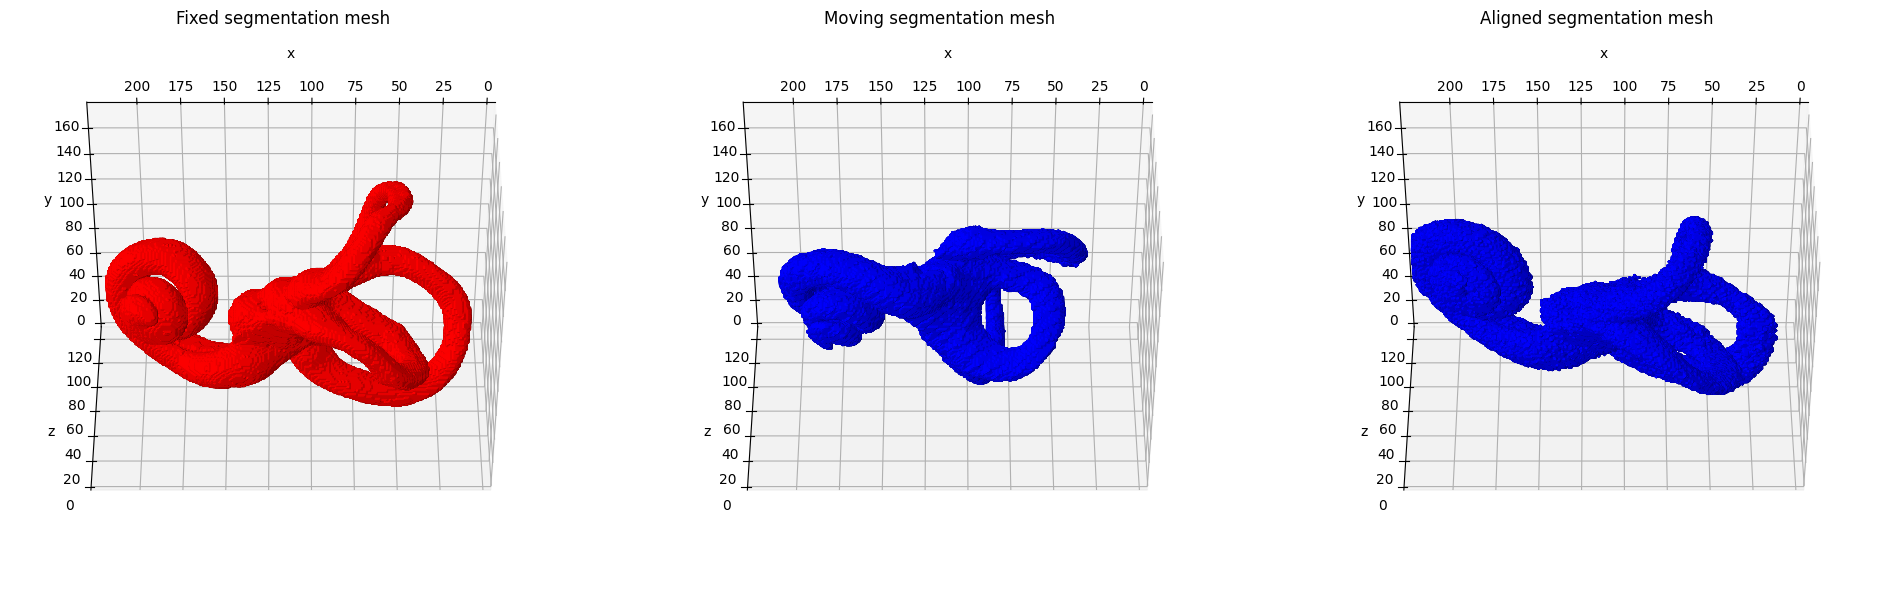

In [20]:
# Display the marching cubes meshes side-by-side

# ShowCase
ls = LightSource(azdeg=225.0, altdeg=45.0)
fig = plt.figure(figsize=(24, 8))

# Set up scene for fixed
ax = fig.add_subplot(1,3,1, projection='3d')
plotMesh(ax, mesh_f, [0, imgDim_fix[0]], [0, imgDim_fix[1]], [0, imgDim_fix[2]], azim=90, elev=-45)
ax.set_title('Fixed segmentation mesh')

# Set up scene for moving
ax = fig.add_subplot(1,3,2, projection='3d')
plotMesh(ax, mesh_m, [0, imgDim_mov[0]], [0, imgDim_mov[1]], [0, imgDim_mov[2]], azim=90, elev=-45)
ax.set_title('Moving segmentation mesh')

# Set up scene for moving
ax = fig.add_subplot(1,3,3, projection='3d')
plotMesh(ax, mesh_a, [0, imgDim_aln[0]], [0, imgDim_aln[1]], [0, imgDim_aln[2]], azim=90, elev=-45)
ax.set_title('Aligned segmentation mesh')

# Display
plt.show()
